In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0-alpha0


In [2]:
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow.keras.utils as utils
import os
import math
import matplotlib.pylab as plt

## 1. 데이터 정의하기

### sine 데이터 정의

200 200


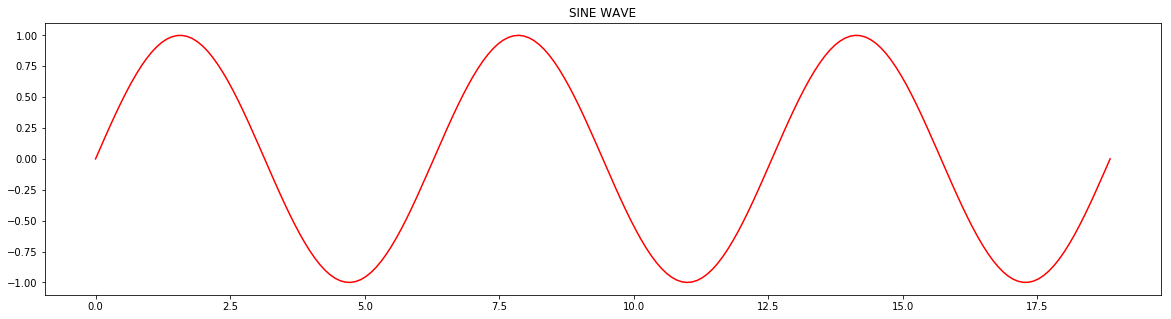

In [3]:
x=np.linspace(0, 6 * np.pi, 200)
y=np.sin(x)

plt.rcParams['figure.figsize'] = [20, 5]

print(len(x), len(y))
plt.plot(x, y, color='r')
plt.title("SINE WAVE")
plt.show()

## 2. 데이터 준비하기

### 데이터셋 생성 함수


In [4]:
def seq2dataset(seq, window_size):
    dataset = []
    
    for i in range(len(seq) - window_size):
        subset = seq[i:(i + window_size + 1)]
        dataset.append([item for item in subset])
    return np.array(dataset)

###  생성

In [5]:
n_steps = 5
n_inputs = 1

dataset = seq2dataset(seq=y, window_size=n_steps)

print("dataset.shape: {0}".format(dataset.shape))

dataset.shape: (195, 6)


### 입력(X)과 출력(Y) 변수로 분리하기

In [6]:
x_train = dataset[:, 0: n_steps]
y_train = dataset[:, n_steps]

print("x_train: {0}".format(x_train.shape))
print("y_train: {0}".format(y_train.shape))

x_train: (195, 5)
y_train: (195,)


### 입력을 (샘플 수, 타입스텝, 특성 수)로 형태 변환

In [7]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_inputs))

In [8]:
print("After pre-processing")
print("x_train: {0}".format(x_train.shape))
print("y_train: {0}".format(y_train.shape))

After pre-processing
x_train: (195, 5, 1)
y_train: (195,)


## 3. 모델 구성하기

In [9]:
model = Sequential()
model.add(LSTM(
    units=10,
    kernel_initializer='glorot_normal',
    bias_initializer='zero',
    batch_input_shape=(1, n_steps, n_inputs), 
    stateful=True
))

model.add(Dense(
    units=1, 
    kernel_initializer='glorot_normal',
    bias_initializer='zero',
    activation="linear"
))

## 4. 모델 학습과정 설정하기

In [10]:
model.compile(
    loss='mse',
    optimizer='adam'
)

## 5. 모델 학습시키기

### 손실 이력 클래스 정의

In [11]:
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.epoch = 0
        self.losses = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
        if self.epoch % 100 == 0:
            print("epoch: {0} - loss: {1:8.6f}".format(self.epoch, logs.get('loss')))
            
        self.epoch += 1

### 학습

In [12]:
num_epochs = 1500
history = LossHistory()  # 손실 이력 객체 생성

history.init()

for epoch_idx in range(num_epochs + 1):
    model.fit(
        x=x_train,
        y=y_train,
        epochs=1,
        batch_size=1,
        verbose=0,
        shuffle=False,
        callbacks=[history]
    )
    if history.losses[-1] < 1e-5:
        print("epoch: {0} - loss: {1:8.6f}".format(epoch_idx, history.losses[-1]))
        model.reset_states()    
        break
    model.reset_states()

epoch: 0 - loss: 0.281627
epoch: 100 - loss: 0.000443
epoch: 200 - loss: 0.000414
epoch: 300 - loss: 0.000242
epoch: 378 - loss: 0.000008


## 6. 학습과정 살펴보기

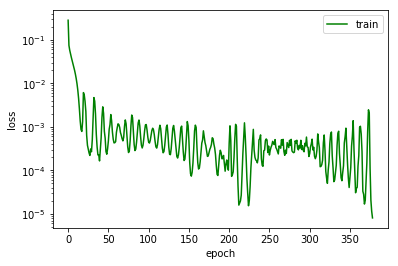

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.losses, color='g')
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

## 7. 모델 평가하기

In [14]:
score = model.evaluate(x_train, y_train, batch_size=1)
print(score)

195/195 [==============================] - 0s 2ms/sample - loss: 9.5681e-06
9.568052784877578e-06


## 8. 모델 사용하기

### 한 스텝 예측

In [15]:
x=np.linspace(0, 6 * np.pi, 200)
y=np.sin(x)

200 200


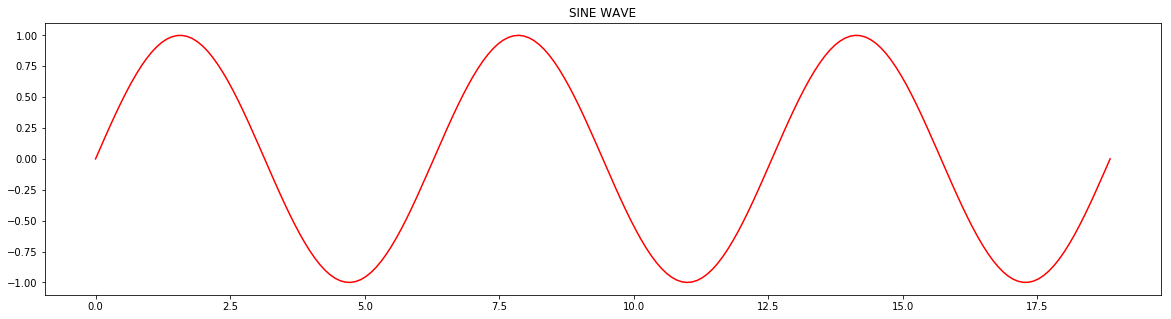

In [16]:
print(len(x), len(y))

plt.rcParams['figure.figsize'] = [20, 5]

plt.plot(x, y, color='r')
plt.title("SINE WAVE")
plt.show()

In [17]:
dataset = seq2dataset(seq=y, window_size=n_steps)

print("dataset.shape: {0}".format(dataset.shape))

x_train = dataset[:, 0: n_steps]
y_train = dataset[:, n_steps]

print("x_train: {0}".format(x_train.shape))
print("y_train: {0}".format(y_train.shape))

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_inputs))

print("After pre-processing")
print("x_train: {0}".format(x_train.shape))
print("y_train: {0}".format(y_train.shape))

dataset.shape: (195, 6)
x_train: (195, 5)
y_train: (195,)
After pre-processing
x_train: (195, 5, 1)
y_train: (195,)


In [18]:
pred_count = 195
pred_out_list = []

pred_out = model.predict(x_train)

for i in range(pred_count):
    pred_out_list.append(pred_out[i][0])  # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장

model.reset_states()

print("one step prediction : ", pred_out_list)

one step prediction :  [0.4221632, 0.556746, 0.59787273, 0.679608, 0.76483333, 0.7915704, 0.8661295, 0.9147459, 0.9258292, 0.9673481, 1.0020938, 0.9906057, 0.9943174, 0.99667823, 0.98100305, 0.9480792, 0.9136907, 0.87586737, 0.82553494, 0.7643266, 0.6991571, 0.6307926, 0.55296195, 0.46995777, 0.38658372, 0.29740527, 0.20452885, 0.11396451, 0.018256754, -0.07612558, -0.1676853, -0.26370823, -0.34904662, -0.44115594, -0.5194795, -0.60287905, -0.6714988, -0.74261117, -0.79939187, -0.85388577, -0.89776754, -0.9342952, -0.9623954, -0.981799, -0.99259806, -0.99470544, -0.9881331, -0.9729428, -0.94922626, -0.91712, -0.87681735, -0.8285881, -0.7728008, -0.70993924, -0.6406076, -0.5654993, -0.48530343, -0.40052393, -0.31141153, -0.2185441, -0.123417705, -0.027548939, 0.06829034, 0.16311479, 0.2561258, 0.34653926, 0.43365526, 0.5165764, 0.5949435, 0.6676245, 0.7344898, 0.79488444, 0.8479887, 0.89398086, 0.93223655, 0.96214175, 0.9838356, 0.997064, 1.0013508, 0.996657, 0.9830831, 0.96059597, 0.92

200 200 200


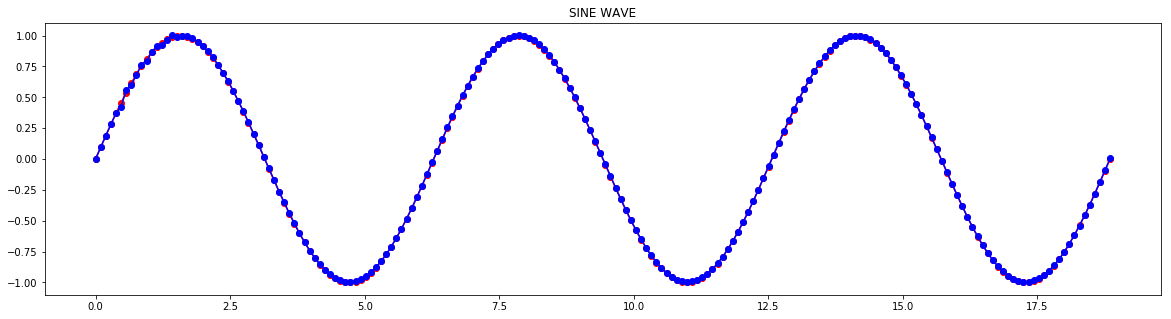

In [19]:
pred_out_list_2 = list(y)[0:5] + list(pred_out_list)

print(len(x), len(y), len(pred_out_list_2))

plt.rcParams['figure.figsize'] = [20, 5]

plt.plot(x, y, marker="o", color='r')
plt.plot(x, pred_out_list_2, marker="o", color='b')
plt.title("SINE WAVE")
plt.show()

### 전체 예측 (시드만을 가지고 전체 곡선 생성)

In [20]:
x=np.linspace(0, 6 * np.pi * (6 / 200), 6)
y=np.sin(x)

dataset = seq2dataset(seq=y, window_size=n_steps)

print("dataset.shape: {0}".format(dataset.shape))

x_train = dataset[:, 0: n_steps]
y_train = dataset[:, n_steps]

print("x_train: {0}".format(x_train.shape))
print("y_train: {0}".format(y_train.shape))

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_inputs))

print("After pre-processing")
print("x_train: {0}".format(x_train.shape))
print("y_train: {0}".format(y_train.shape))

dataset.shape: (1, 6)
x_train: (1, 5)
y_train: (1,)
After pre-processing
x_train: (1, 5, 1)
y_train: (1,)


In [21]:
pred_count = 195
pred_out_list = []


for i in range(pred_count):
    pred_out = model.predict(x_train)
    pred_out_value = pred_out[0][0]
    
    pred_out_list.append(pred_out_value)
    
    x_train = list(np.reshape(x_train, (n_steps,)))
    x_train.append(pred_out_value)
    x_train.pop(0)
    x_train = np.array(x_train)
    x_train = np.reshape(x_train, (1, n_steps, n_inputs))

print(len(pred_out_list))

195


200 200


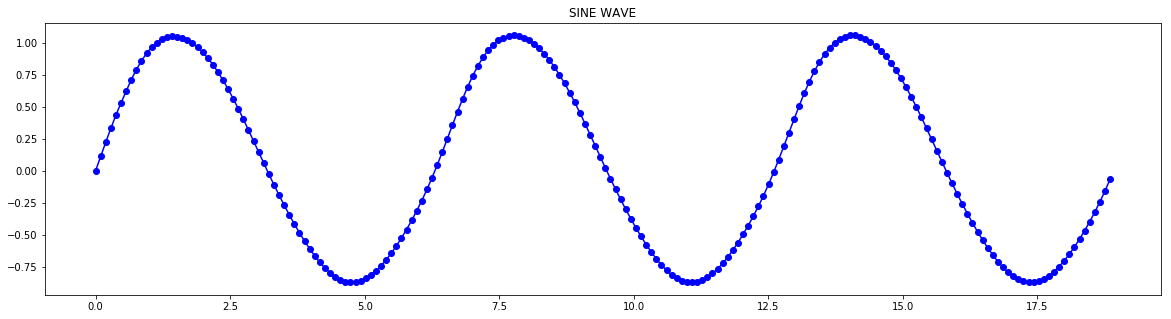

In [22]:
x=np.linspace(0, 6 * np.pi, 200)

pred_out_list_2 = list(y)[0:5] + list(pred_out_list)

print(len(x), len(pred_out_list_2))

plt.rcParams['figure.figsize'] = [20, 5]

plt.plot(x, pred_out_list_2, marker="o", color='b')
plt.title("SINE WAVE")
plt.show()